In [527]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from scipy import stats
import graphviz
from graphviz import Graph

import env
import acquire
import split_scale
#import features
import prep
#import exploration
#import feature_selection
#import model

### Acquisition and initial data exploration

In [528]:
df = acquire.prep_telco()

In [529]:
df = df[(df.internet_service_type_id ==1) & (df.contract_type_id==1) &(df.phone==False)]

df.describe().transpose()

AttributeError: 'DataFrame' object has no attribute 'phone'

In [ ]:
df.head()

### Initial data prep

Several fields needed to be cleaned up, converted to booleans, and combined.

- Total charges had 13 blank values that were dropped from the dataset. That is too few records to significantly impact our analysis


- churn, senior_citizen, gender, paperless_billing all converted to boolean values.


- Combined fields: partner/dependents to family, phone_service/multiple_lines to phone, streaming_tv/streaming_movies to streaming, device_protection/tech_support to tech_protection, and online_backup/online_security to internet_security

In [ ]:
df = prep.clean_telco(df)

### Senior leadership questions and initial hypothesis

Based on our current understanding of the business. We believe that churn is highly based on short tenured customers.

Initial exploration included addressing the questions presented by the senior leadership to get an idea of what our data was telling us. As well as testing our initial hypothesis of tenure driving churn.

##### Is there a month where a customer is more likely to churn?

The scatterplot below shows customer tenure on the x axis and churn rate on the y axix. 

You can see a clear rise in churn rate for newer customers. 

In [ ]:
prep.tenure_churn(df)

##### Is there a tenure that month to month are most likely to churn? 1 year contracts? 2 year contracts?

The chart below shows the breakout of churn by contract type. 

Newer customers are still more likely to churn across the board but now we see that month to month contracts really stand out in the early months. 

There could be several factors driving this loss in early customers. They may be testing out our services and not enjoying the quality enough to stay. The competition could also be targeting our customers that are not locked into lengthy contracts. If we want to keep this contract type we need to address our onboarding process to ensure our new customers have the highest possible satisfaction in the first few weeks of using our services. It may help to incentivize our newer m2m customers to switch to 1 or 2 year contracts if possible

In [ ]:
prep.contract_churn(df)

##### Are there features that indicate a higher propensity to churn? Internet type? phone service? online security/backup? senior citizen? paying more than x% of customers?


Internet type was a strong indicator of churn. Fiber and DSL customers were both more likely to churn than those with no internet.

In [530]:
prep.internet_churn(df)

TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Phone service was not a strong indicator of churn.

In [531]:
prep.phone_churn(df)

KeyError: "['phone'] not in index"

Customers without online security or online backup were significantly more likely to churn than those with it.

In [532]:
prep.security_churn(df)

TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [533]:
prep.backup_churn(df)

TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Seniors were somewhat more likely to churn.

In [534]:
prep.senior_churn(df)

TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

##### Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point?

The data shows that there is not a clear price point where churn shifts dramatically. 

In [535]:
prep.charges_churn(df)

TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

The below chart shows that our highest churning customers are also bringing in the most revenue. We need to work to upsell our stable and lower tier customers to better service packages.

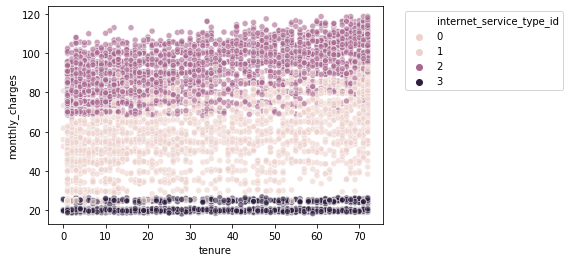

In [536]:
prep.charges_distro(df)

In [537]:
prep.quantile_churn(df)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

### Data prep

- Converting churn and senior citizen to boolean.
- Combining partner and dependents into one variable called 'family' if either column is Yes.
- Combining phone_service and multiple_lines into one variable called phone if either column is Yes.



In [ ]:
df = prep.drop_columns(df)

#### Split and Scale

In [ ]:
train, test = split_scale.split_my_data(df,train_ratio=.8,seed=123,stratify=None)

#### Create X and y train/test

In [538]:
X_train = train.drop(['churn'],axis=1)
y_train = train.churn
X_test = test.drop(['churn'],axis=1)
y_test = test.churn

#### Fit model to training data

In [539]:
clf = DecisionTreeClassifier(criterion='entropy',max_depth=4,random_state=123)

In [540]:
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [541]:
y_pred = clf.predict(X_train)

In [542]:
y_pred_prob = clf.predict_proba(X_train)
y_pred_prob

array([[0.72477064, 0.27522936],
       [0.48837209, 0.51162791],
       [0.25974026, 0.74025974],
       ...,
       [0.72477064, 0.27522936],
       [1.        , 0.        ],
       [0.48837209, 0.51162791]])

In [543]:
prep.model_accuracy(X_train,y_train,X_test,y_test,clf)

The train data had an accuracy of:  0.7321063394683026
The test data had an accuracy of:  0.6285714285714286


We have a prediction accuracy rate of 79%. This is a solid score for a baseline model but I believe with a bit of tweaking to the model we can improve.

The confusion matrix below shows that we are struggling a bit with type 1 and type 2 errors, incorrectly marking customers we deem likely to churn and stayed. As well as those that will churn that we are not identifying. This is something we will work on in future models.

In [544]:
confusion_matrix(y_train,y_pred)

array([[593,  83],
       [179, 123]])

The below chart shows that we are far more precise predicting those that will not churn.

In [545]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

       False       0.77      0.88      0.82       676
        True       0.60      0.41      0.48       302

    accuracy                           0.73       978
   macro avg       0.68      0.64      0.65       978
weighted avg       0.72      0.73      0.72       978



A breakdown of the decision tree for the baseline model.

In [491]:
# dot_data = export_graphviz(clf,out_file=None)
# graph = graphviz.Source(dot_data)
# graph.render('telco_churn',view=True)

The below table shows our scored features from the baseline model. contract type, monthly charges, and tenure were the strongest features with a few other minor drivers. Quite a few of our features provided no value. This information will be taken into account when working on the mvp.

In [492]:
prep.key_features(clf,X_train)

,0,1
0,internet_service_type_id,0.3742
1,tenure,0.2561
2,monthly_charges,0.1280
3,total_charges,0.1173
4,payment_type_id,0.0770
5,paperless_billing,0.0212
6,internet_security,0.0136
7,is_male,0.0126
8,senior_citizen,0.0000
9,contract_type_id,0.0000


In [493]:
predictions_df = pd.concat([X_train,X_test])

In [463]:
y_pred_prob = clf.predict_proba(predictions_df)
y_pred_prob

array([[0.43      , 0.57      ],
       [0.25316456, 0.74683544],
       [1.        , 0.        ],
       ...,
       [0.49230769, 0.50769231],
       [0.        , 1.        ],
       [0.43      , 0.57      ]])

In [464]:
y_predictions = pd.DataFrame({'probability_of_churn': y_pred_prob[:,1],'churned':(y_pred_prob[:,1] >=.5) == 1})

y_predictions = y_predictions.set_index(df.index)

In [465]:
y_predictions.to_csv(r'churn_probability_predictions.csv')

#### Conclusion

After initial exploration, analysis, and modeling we have a much stronger understanding of the factors driving churn. We know that contract type, tenure, and services received are strong drivers.

- As a company we need to address the flight of fiber customers. We could do this with promotion programs and addressing quality issues within our fiber product.

- New customers are also churning at a much higher rate. I believe we can address this with incentive programs to shift them to 6mo or 1year contracts at a discounted rate as well as potentially implementing a cancelation fee to disincentivize leaving.

- 